In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from NetEmbs import *
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.figsize"] = [20,10]
set_font(16)

In [3]:
embs = pd.read_pickle("model/tmps/tmp_dataMarcel.pkl")

In [3]:
cur_path= "model/"+WORK_FOLDER[0]+WORK_FOLDER[1]

In [3]:
embs_bad = pd.read_pickle("model/2_walks30_pressure30_window3/TFsteps200000batch64_emb32/cache/Embeddings.pkl")

In [4]:
embs = pd.read_pickle(cur_path+"cache/Embeddings.pkl")

In [6]:
embs.head()

,ID,Emb,GroundTruth
0,1,"[0.12368746, 0.161482, 0.28400204, -0.1822038,...",Purchase
1,3,"[0.115511775, 0.03801798, -0.06206809, -0.2260...",Sales 21 btw
2,4,"[-0.47322965, -0.04450774, -0.008095294, -0.17...",Cost of Sales
3,5,"[-0.21242754, -0.23674373, 0.053790133, 0.0479...",Fixed Assets
4,6,"[0.1002198, 0.18796788, -0.201984, 0.20154962,...",Tax disbursement


Collections


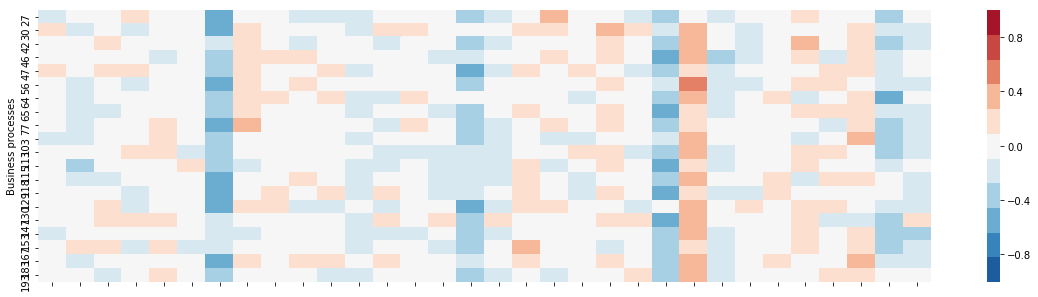

/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Cost of Sales


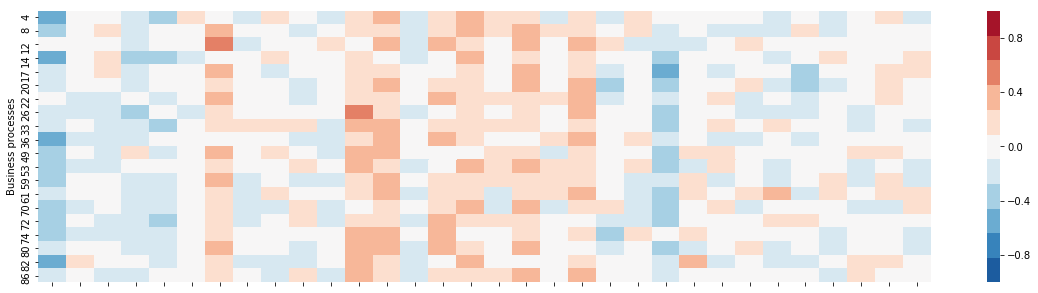

Depreciation


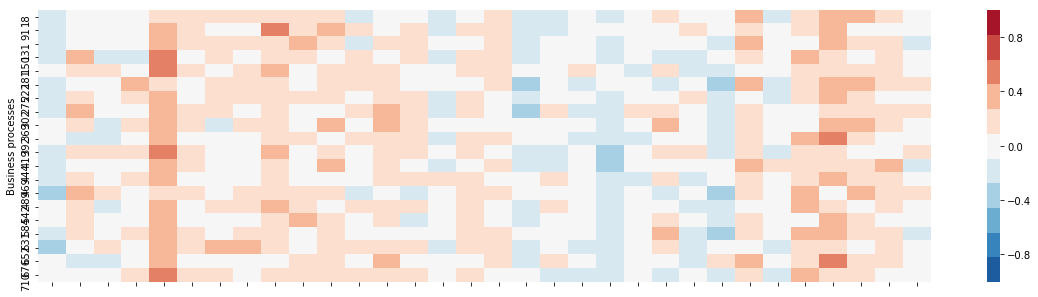

Fixed Assets


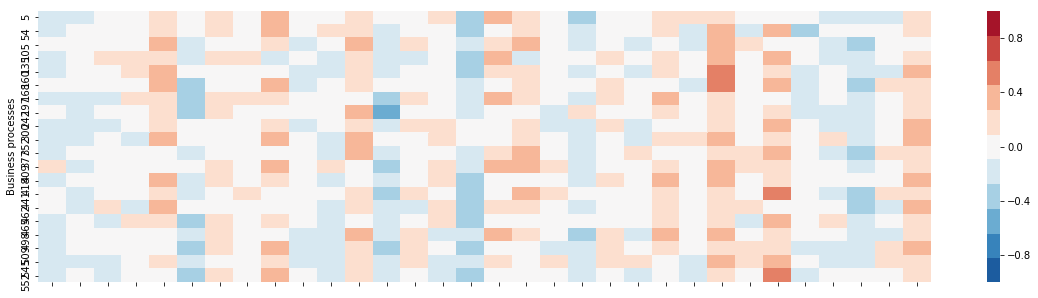

Payroll


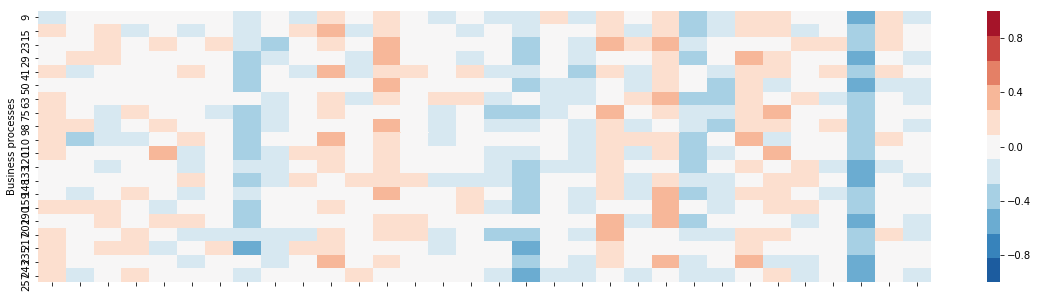

Payroll Disbursement
Not enough samples...
Purchase


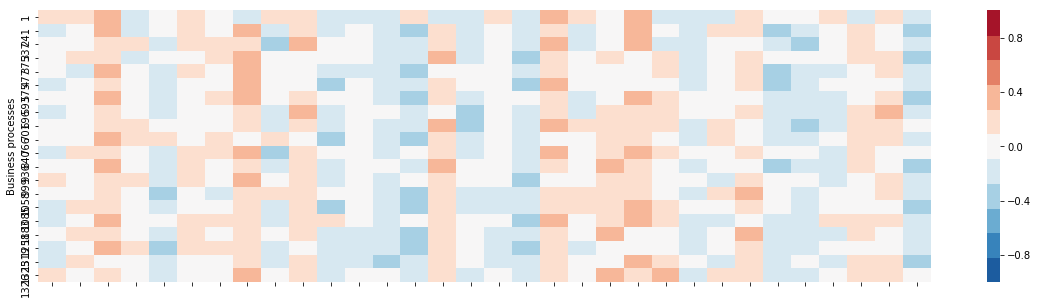

Sales 21 btw


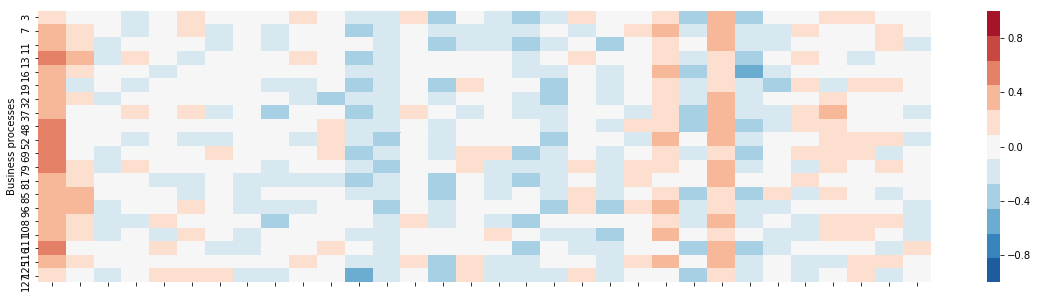

Sales 6 btw


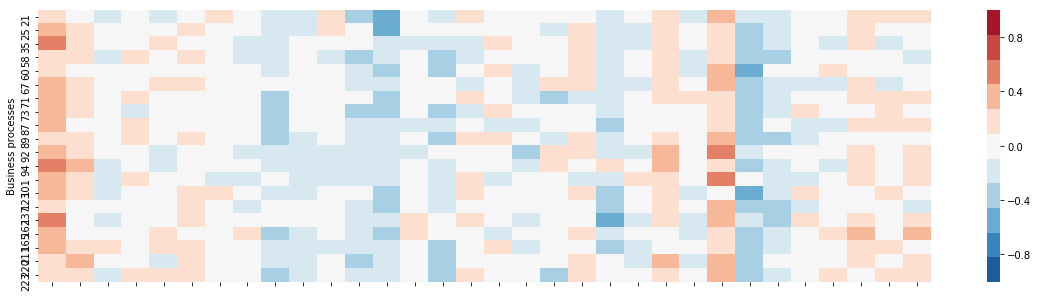

Tax disbursement
Not enough samples...


In [7]:
dims = 20
ns = 11
sm_embs = pd.DataFrame(columns=list(embs)+["Legend"])
for name, group in embs.groupby("GroundTruth"):
    print(name)
    if group.shape[0] > 3:
        plt.figure(figsize=(20, 5))
        sns.heatmap(list(group["Emb"].values[:dims]), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 11))
        frame1 = plt.gca()
        frame1.axes.set_xlabel('')
        frame1.axes.set_ylabel('Business processes')
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels(list(group["ID"].values[:dims]))
        plt.show()
        app = group.head(ns).copy()
#         app["Legend"] = np.array([None, None, group["GroundTruth"].values[0], None, None])
        sm_embs = sm_embs.append(app, sort=False).append(pd.DataFrame({"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}))
    else:
        print("Not enough samples...")

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


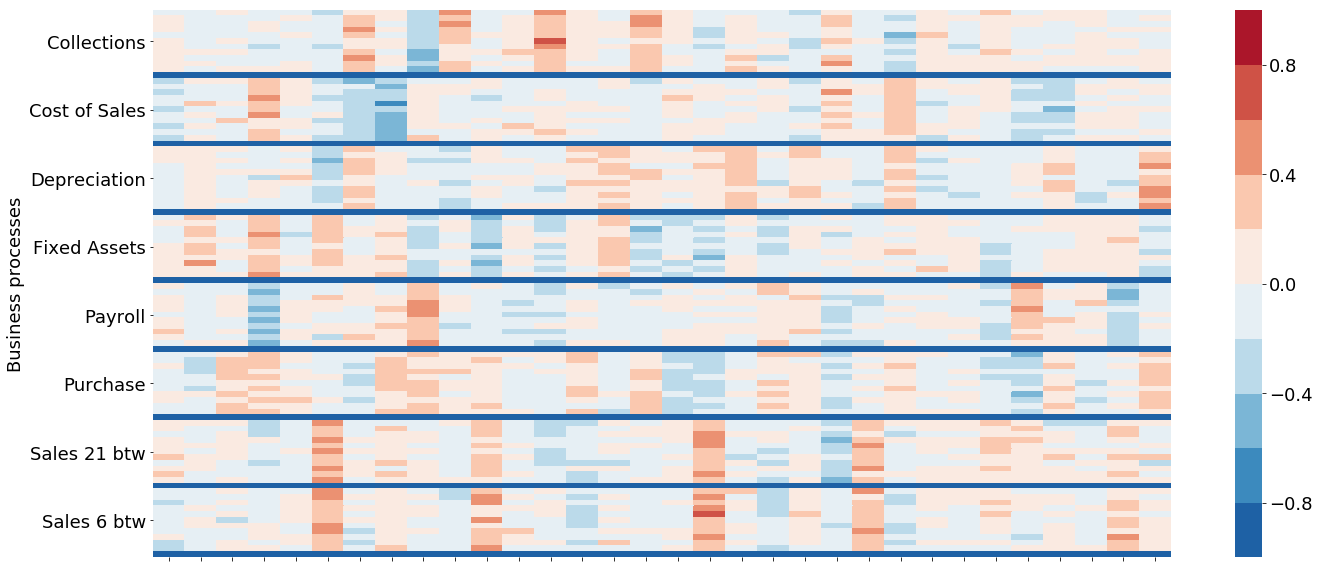

In [17]:
def groupVectors(df, how="median", samples_per_group=11, print_info=False):
    means = dict()
    pretty_vectors = pd.DataFrame(columns=list(df))
    for name, group in df.groupby("GroundTruth"):
        if group.shape[0] > samples_per_group:
            cur_data = group.copy()
            if how=="mean":
                means[name] = np.mean(group["Emb"].values, axis=0)
            elif how=="median":
                means[name]=np.median(group["Emb"].values.tolist(), axis=0)
            elif how=="random":
                means[name]=group["Emb"].values[0]
            cur_data["Similarity"] = cur_data["Emb"].apply(lambda x: 
                                                     cosine_similarity(X=means[name].reshape(1, -1), Y=x.reshape(1, -1)))
            cur_data.sort_values("Similarity", ascending=False, axis=0, inplace=True)
            if print_info:
                print("-----"+name+"-----")
                print("Highest similarity: \n", cur_data.Similarity.head(2), "\nLowest similarity: \n", cur_data.Similarity.tail(2))
            app = cur_data.head(samples_per_group).copy()
            pretty_vectors = pretty_vectors.append(app, sort=True).append(pd.DataFrame(
                {"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}), sort=False)
        else:
            print("For group ", name, " is not enough samples...")
    return pretty_vectors

plotVectors(groupVectors(embs, how="mean"), title="prettyVectorsMean")

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


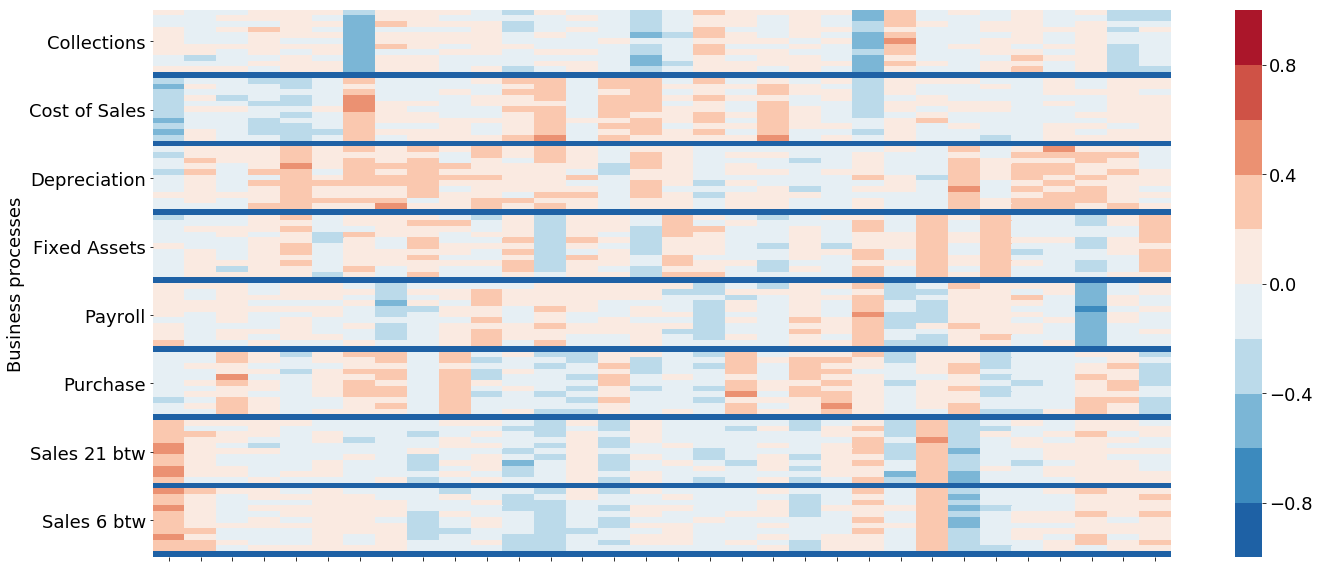

In [12]:
plotVectors(groupVectors(embs, how="mean"), title="prettyVectorsMean", folder=cur_path)

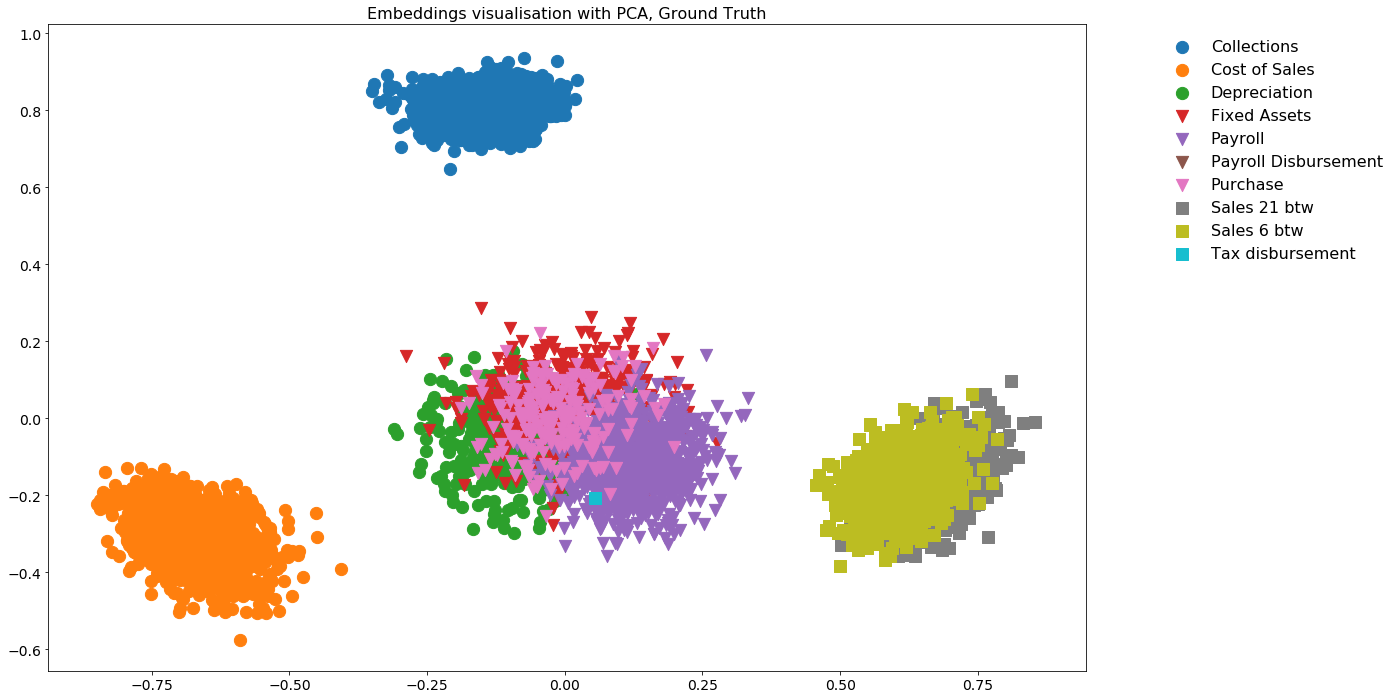

In [9]:
plot_PCA(embs, legend_title="GroundTruth", title="PCA", folder=cur_path)

## Clustering score

In [5]:
str_labels = list(embs.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
real_labels
from sklearn.metrics import v_measure_score

In [25]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
def getScores(df, cl_method, n_max):
    cl = pd.DataFrame(list(map(np.ravel, df.iloc[:, 1])))
    print("First row of Data: \n", cl.iloc[0].values)
    cur_score = 0.0
    cur_num_cl = 2
    scores = list()
    v_scores = list()
    for cur_cl in range(2, n_max):
        km = cl_method(n_clusters=cur_cl)
        predicted_labels = km.fit_predict(cl)
        silhouette_avg = silhouette_score(cl, predicted_labels)
        df["true_labels"] = df.GroundTruth.apply(lambda x: real_labels[x])
        v_scores.append(v_measure_score(df.true_labels.values, predicted_labels))
        scores.append(silhouette_avg)
    return list(range(2, n_max)), scores, v_scores
stat_cl = getScores(embs, KMeans, 15)
stat_cl

First row of Data: 
 [ 0.12368746  0.16148201  0.28400204 -0.1822038  -0.01041532  0.19145691
 -0.04531923 -0.1099734   0.11243144  0.24120098 -0.24969444 -0.11636365
 -0.26797307  0.12636764 -0.12432895 -0.16619056  0.1244036  -0.14882822
  0.31279764  0.18567431 -0.03101954  0.27960882 -0.18066119 -0.20350444
 -0.16964948  0.16228737  0.08411545  0.06023566  0.10772441 -0.10394842
  0.24194075 -0.21538179]


([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [0.19295992098092588,
  0.25348006271655116,
  0.3169152106017051,
  0.34914485065249884,
  0.3666649562392289,
  0.3799755817625801,
  0.29595108192264374,
  0.2139037018934266,
  0.20743551493265383,
  0.16176284084086295,
  0.14158394540403083,
  0.09558040680865218,
  0.08991345063513272],
 [0.46447675986649645,
  0.7021285107160541,
  0.8256001584415735,
  0.8978269658949004,
  0.9296351480686541,
  0.9479921330423869,
  0.9797025256227941,
  0.9390106777377423,
  0.910048628512765,
  0.8936320776570479,
  0.8671740580931047,
  0.8559260183669429,
  0.8321631813830985])

In [31]:
str_labels = list(embs.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
def getColors(c):
    cmap = cm.get_cmap('tab10', c)    # PiYG
    colors_list = list()
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        colors_list.append(matplotlib.colors.rgb2hex(rgb))
    return colors_list
colors_list = dict(zip(str_labels, getColors(len(str_labels))))
def plot_tSNE(fsn_embs, title="tSNE", folder="", legend_title="GroundTruth", rand_state=1):
    import os
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    tsne = TSNE(random_state=rand_state)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs["Emb"])))
    embed_tsne = tsne.fit_transform(embdf)
    fsn_embs["x"] = pd.Series(embed_tsne[:, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:, 1])
    markers = ["o", "v", "s"]
    cur_m = 0
    plt.clf()
    n_gr = 0
    for name, group in fsn_embs.groupby(legend_title):
        n_gr += 1
        if n_gr > 3:
            cur_m = cur_m + 1 if len(markers) - 1 > cur_m else 0
            n_gr = 0
        cur_color = colors_list[group.groupby(legend_title).GroundTruth.agg(pd.Series.mode).values[0]]
        plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], c=cur_color, label=name)
    plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", frameon=False, markerscale=1.4)
    if legend_title == "GroundTruth":
        plt.title("Embeddings visualisation with t-SNE, Ground Truth")
    elif legend_title == "label":
        from sklearn.metrics import v_measure_score
        plt.title("Embeddings visualisation with t-SNE, predicted labels, V-Score is "+str(v_measure_score(fsn_embs.true_labels.values, fsn_embs.label.values).round(3)))

    if title is not None and isinstance(title, str):
        plt.tight_layout()
        postfix = ""
        if folder == "":
            postfix = "_" + "batch" + str(BATCH_SIZE) \
                      + "_emb" + str(EMBD_SIZE) \
                      + "_walks" + str(WALKS_PER_NODE) \
                      + "_TFsteps" + str(STEPS)
        plt.savefig(folder + "img/" + title + postfix, dpi=140, pad_inches=0.01)

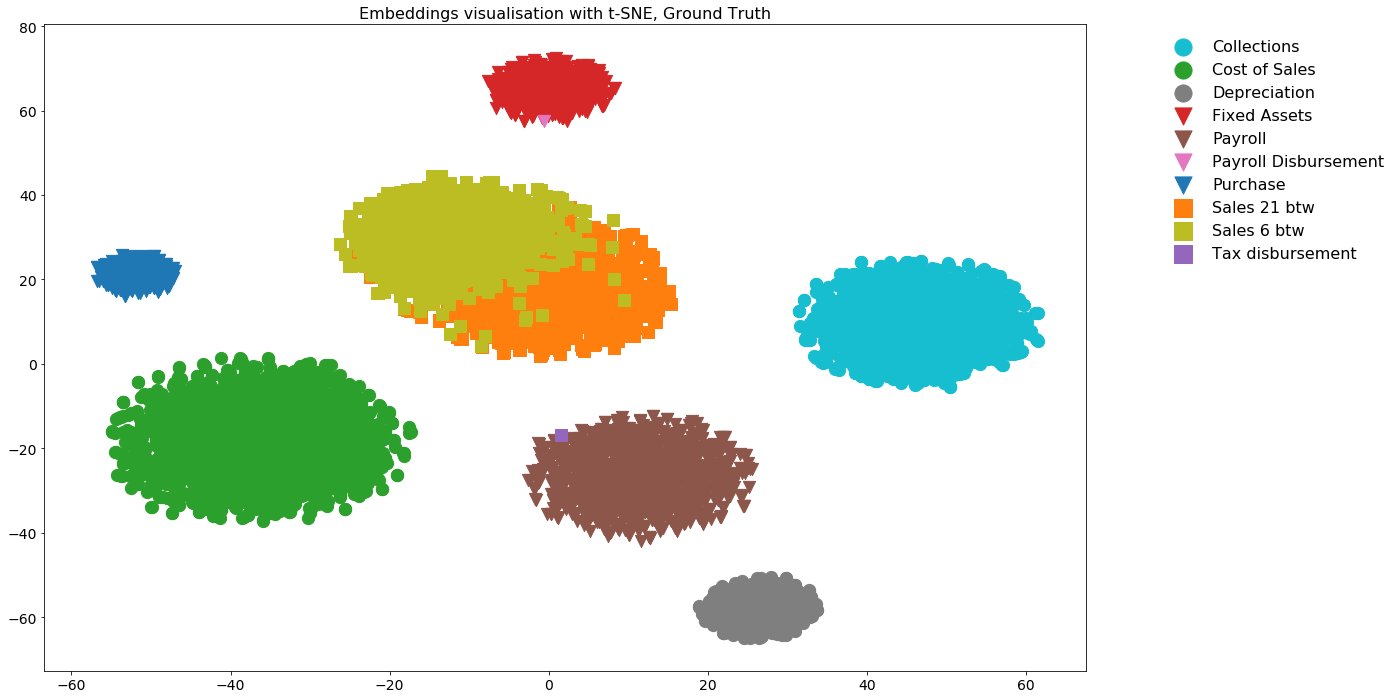

In [32]:
plot_tSNE(cl_dataKM, legend_title="GroundTruth", title="GT_new", folder=cur_path)

## KMeans

In [67]:
cl_dataKM = cl_KMeans(embs, 7)
cl_dataKM["true_labels"] = cl_dataKM.GroundTruth.apply(lambda x: real_labels[x])
v_measure_score(cl_dataKM.true_labels.values, cl_dataKM.label.values)

First row of Data: 
 [ 0.12368746  0.16148201  0.28400204 -0.1822038  -0.01041532  0.19145691
 -0.04531923 -0.1099734   0.11243144  0.24120098 -0.24969444 -0.11636365
 -0.26797307  0.12636764 -0.12432895 -0.16619056  0.1244036  -0.14882822
  0.31279764  0.18567431 -0.03101954  0.27960882 -0.18066119 -0.20350444
 -0.16964948  0.16228737  0.08411545  0.06023566  0.10772441 -0.10394842
  0.24194075 -0.21538179]


0.9479921330423869

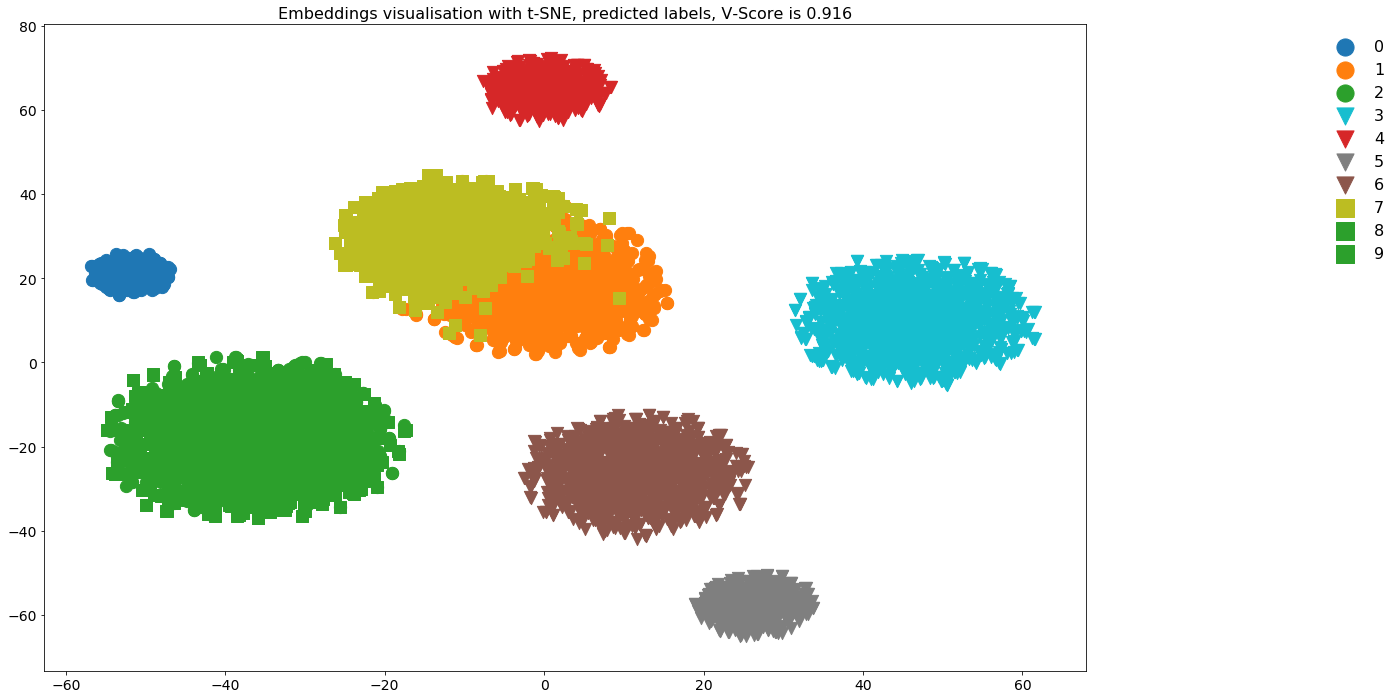

In [39]:
plot_tSNE(cl_dataKM, legend_title="label", title="KMeans10_new", folder=cur_path)

In [69]:
def combineAndSummarize(df_emb):

#     combiC = df_emb.groupby(["FA_Name", "from", "label"]).agg('sum')
#     combiG = df_emb.groupby(["FA_Name", "from", "GroundTruth"]).agg('sum')
    totalCombi = df_emb.groupby(["label", "GroundTruth"]).agg('count')
    return totalCombi
#     return combiC, combiG, totalCombi
totalCombi= combineAndSummarize(cl_dataKM)
pivot = totalCombi["ID"].unstack().fillna(0)

pivotRel = pivot.apply(lambda x: (x * 100) / x.sum(), axis = 0)

pivotRel.T.to_excel(cur_path+"BigTestKM7.xlsx")

In [54]:
totalCombi

ID   Emb  true_labels     x     y
label GroundTruth                                              
0     Purchase               236   236          236   236   236
1     Sales 21 btw           923   923          923   923   923
      Sales 6 btw             27    27           27    27    27
2     Cost of Sales          571   571          571   571   571
3     Collections           1172  1172         1172  1172  1172
4     Fixed Assets           430   430          430   430   430
      Payroll Disbursement     1     1            1     1     1
5     Depreciation           410   410          410   410   410
6     Payroll               1060  1060         1060  1060  1060
      Tax disbursement         1     1            1     1     1
7     Sales 21 btw            33    33           33    33    33
      Sales 6 btw            890   890          890   890   890
8     Cost of Sales          551   551          551   551   551
9     Cost of Sales          539   539          539   539   539

In [55]:
from collections import Counter
pred_labels = sorted(list(cl_dataKM.label.unique()))
true_labels = sorted(list(cl_dataKM.GroundTruth.unique()))
confuse_me = dict().fromkeys(pred_labels, dict().fromkeys(true_labels, 0))
for name, group in cl_dataKM.groupby("label"):
    cnt = dict(Counter(group.GroundTruth.values.tolist()))
    tmp = confuse_me[name].copy()
    tmp.update(cnt)
    confuse_me[name]=tmp
confuse_me

{0: {'Collections': 0,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 0,
  'Purchase': 236,
  'Sales 21 btw': 0,
  'Sales 6 btw': 0,
  'Tax disbursement': 0},
 1: {'Collections': 0,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 0,
  'Purchase': 0,
  'Sales 21 btw': 923,
  'Sales 6 btw': 27,
  'Tax disbursement': 0},
 2: {'Collections': 0,
  'Cost of Sales': 571,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 0,
  'Purchase': 0,
  'Sales 21 btw': 0,
  'Sales 6 btw': 0,
  'Tax disbursement': 0},
 3: {'Collections': 1172,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 0,
  'Purchase': 0,
  'Sales 21 btw': 0,
  'Sales 6 btw': 0,
  'Tax disbursement': 0},
 4: {'Collections': 0,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 430,
  'Payroll': 0,
  'Payroll Disburseme

## Agglomerative

First row of Data: 
 [ 0.12368746  0.16148201  0.28400204 -0.1822038  -0.01041532  0.19145691
 -0.04531923 -0.1099734   0.11243144  0.24120098 -0.24969444 -0.11636365
 -0.26797307  0.12636764 -0.12432895 -0.16619056  0.1244036  -0.14882822
  0.31279764  0.18567431 -0.03101954  0.27960882 -0.18066119 -0.20350444
 -0.16964948  0.16228737  0.08411545  0.06023566  0.10772441 -0.10394842
  0.24194075 -0.21538179]
0.8792034640805708


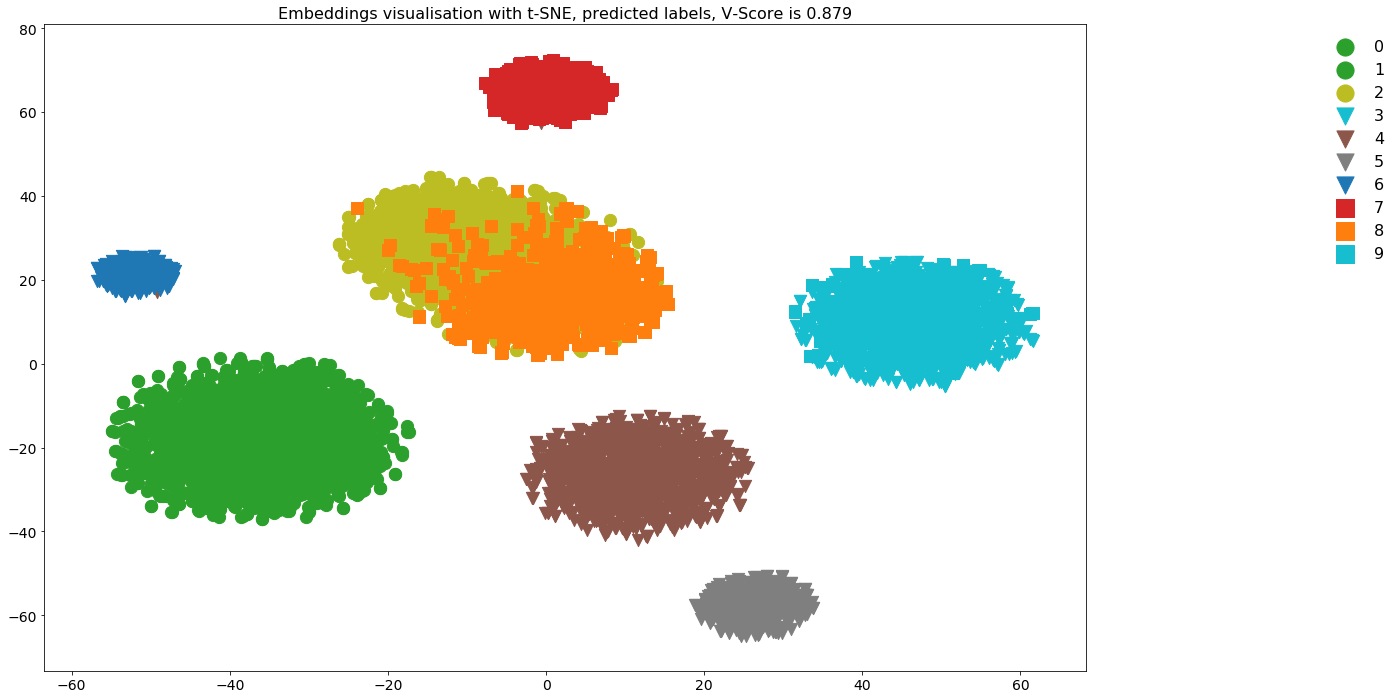

In [43]:
cl_data = cl_Agglomerative(embs, 10)
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])
print(v_measure_score(cl_data.true_labels.values, cl_data.label.values))
plot_tSNE(cl_data, legend_title="label", title="Agg10", folder=cur_path)

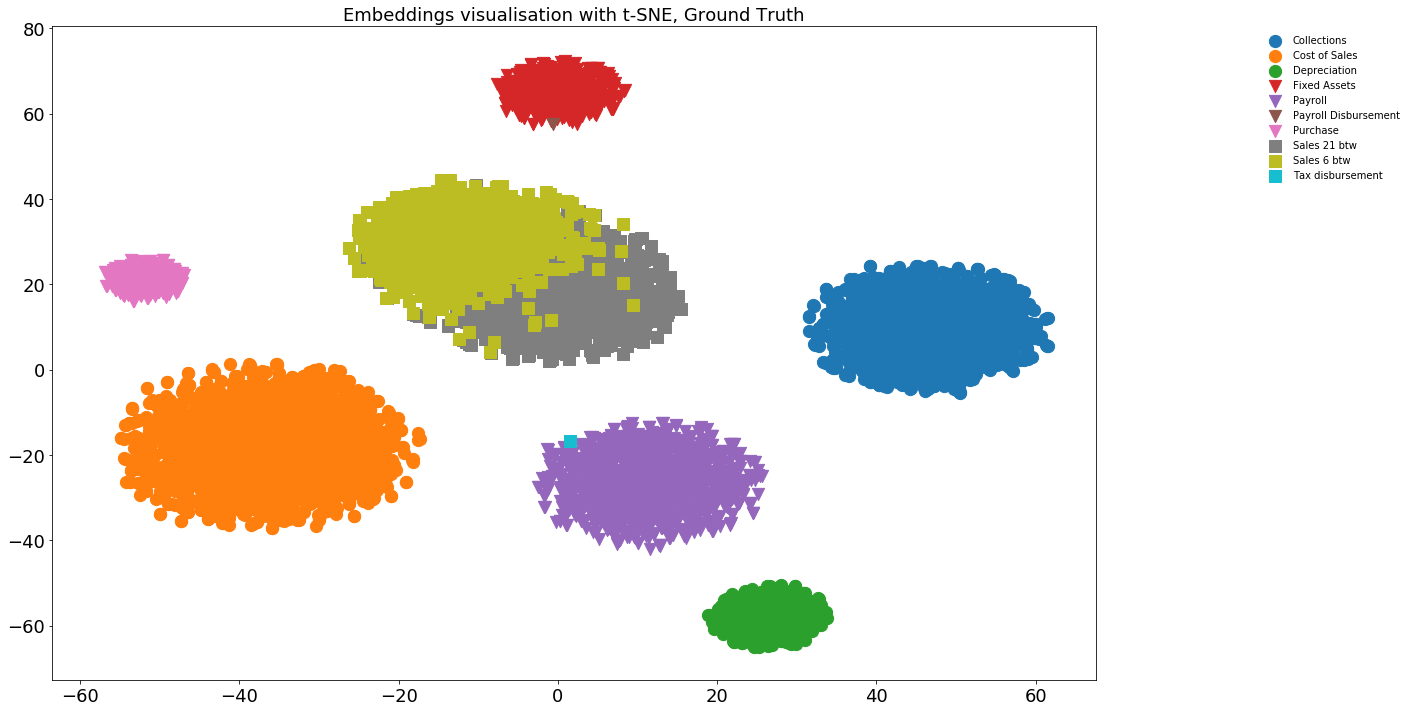

In [18]:
plot_tSNE(cl_data, legend_title="GroundTruth", title="GT", folder=cur_path)

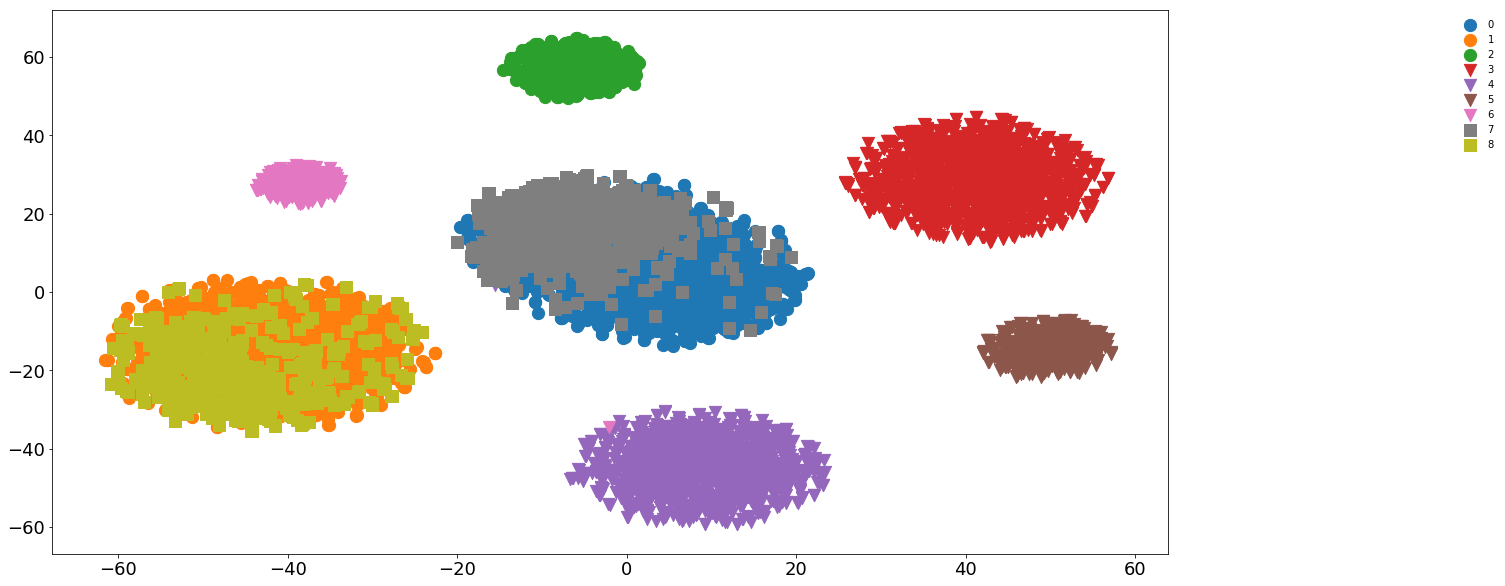

In [28]:
plot_tSNE(cl_data, legend_title="label", title=None)

In [34]:
def plot_PCA(fsn_embs, title="PCA", folder="", legend_title="GroundTruth", rand_state=1):
    import os
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    pca = PCA(n_components=2)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs["Emb"])))
    embed_tsne = pca.fit_transform(embdf)
    fsn_embs["x"] = pd.Series(embed_tsne[:, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:, 1])
    markers = ["o", "v", "s"]
    cur_m = 0
    plt.clf()
    n_gr = 0
    for name, group in fsn_embs.groupby(legend_title):
        n_gr += 1
        if n_gr > 3:
            cur_m = cur_m + 1 if len(markers) - 1 > cur_m else 0
            n_gr = 0
        plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], label=name)
    plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", frameon=False, markerscale=1)
    if legend_title == "GroundTruth":
        plt.title("Embeddings visualisation with PCA, Ground Truth")
    elif legend_title == "label":
        plt.title("Embeddings visualisation with PCA, predicted labels")

    if title is not None and isinstance(title, str):
        plt.tight_layout()
        postfix = ""
        if folder == "":
            postfix = "_" + "batch" + str(BATCH_SIZE) \
                      + "_emb" + str(EMBD_SIZE) \
                      + "_walks" + str(WALKS_PER_NODE) \
                      + "_TFsteps" + str(STEPS)
        plt.savefig(folder + "img/" + title + postfix, dpi=140, pad_inches=0.01)

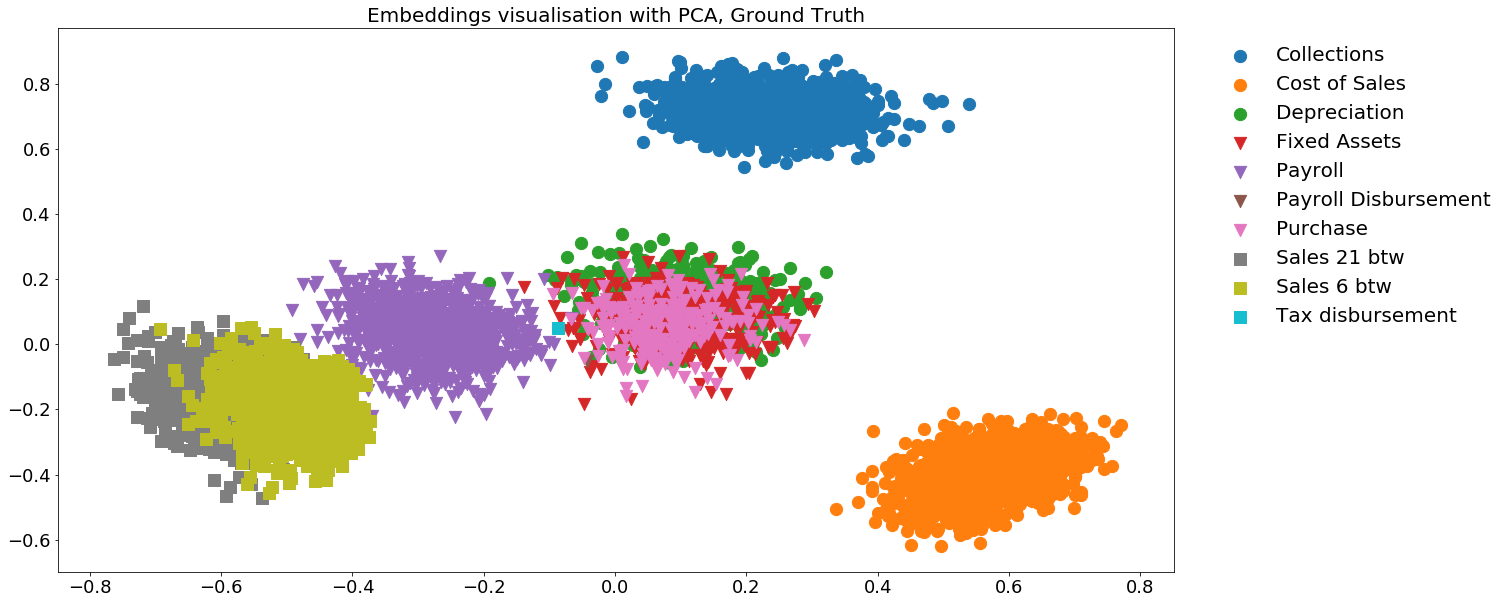

In [36]:
set_font(20)
plot_PCA(cl_data, legend_title="GroundTruth", title=None)

In [ ]:
from collections import Counter
pred_labels = sorted(list(cl_data.label.unique()))
true_labels = sorted(list(cl_data.GroundTruth.unique()))
confuse_me = dict().fromkeys(pred_labels, dict().fromkeys(true_labels, 0))
for name, group in cl_data.groupby("label"):
    cnt = dict(Counter(group.GroundTruth.values.tolist()))
    tmp = confuse_me[name].copy()
    tmp.update(cnt)
    confuse_me[name]=tmp
confuse_me

# Word count for FAs

In [70]:
d = upload_data("Simulation/FSN_Data.db", limit=None)
d.head(4)
journal_entries = None
if journal_entries is None:
    d = prepare_data(d)
else:
    YOUR_DATAFRAME = pd.DataFrame.from_dict(journal_entries)
    YOUR_DATAFRAME.columns = ['ID', 'FA_Name', 'Debit', 'Credit']
    d = prepare_data(YOUR_DATAFRAME, split=False)
d.head(4)

Original shape of DataFrame is  (60705, 4)
Deleted all NaNs and Strings values from 'Value' column:  (60705, 4)
Before merging FAs columns titles are:  ['ID', 'Name', 'FA_Name', 'Value', 'Debit', 'Credit']
After merging FAs columns titles are:  ['ID', 'FA_Name', 'Credit', 'Debit', 'Name', 'Value']  shape is  (60605, 6)
After normalization shape of DataFrame is  (60605, 7)
Final shape of DataFrame is  (52232, 8)


,ID,Signature,FA_Name,Credit,Debit,Name,Value,from
0,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_hvlh,0.003932,0.0,NoisyLeftFA_hvlh_9,-0.871915,True
1,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_iawn,0.000292,0.0,NoisyLeftFA_iawn_9,-0.064821,True
2,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_mzjd,0.003658,0.0,NoisyLeftFA_mzjd_9,-0.811047,True
3,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",OtherExpenses,0.401357,0.0,OtherExpenses_9,-89.000000,True


In [71]:
w_cnt = d.merge(cl_dataKM, on="ID")

In [72]:
w_cnt["amount"] = w_cnt["Value"].apply(lambda x: abs(x)*100)

In [11]:
d.Signature.head(2).values

array(["([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA_iawn', 0.00029), ('NoisyLeftFA_mzjd', 0.00366), ('OtherExpenses', 0.40136), ('PersonnelExpenses', 0.25705), ('PrepaidExpenses', 0.33371)], [('TradePayables', 1.0)])",
       "([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA_iawn', 0.00029), ('NoisyLeftFA_mzjd', 0.00366), ('OtherExpenses', 0.40136), ('PersonnelExpenses', 0.25705), ('PrepaidExpenses', 0.33371)], [('TradePayables', 1.0)])"],
      dtype=object)

In [73]:
w_cnt.head(2)

,ID,Signature,FA_Name,Credit,Debit,Name,Value,from,Emb,GroundTruth,label,true_labels,x,y,amount
0,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_hvlh,0.003932,0.0,NoisyLeftFA_hvlh_9,-0.871915,True,"[0.12368746, 0.161482, 0.28400204, -0.1822038,...",Purchase,6,0,-49.166592,17.093376,87.191468
1,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_iawn,0.000292,0.0,NoisyLeftFA_iawn_9,-0.064821,True,"[0.12368746, 0.161482, 0.28400204, -0.1822038,...",Purchase,6,0,-49.166592,17.093376,6.482113


Current cluster label is  0
Left ---> [('Inventory', 1661, 82192332.2998623), ('NoisyLeftFA_tbxa', 17, 3109.6849557031705), ('NoisyLeftFA_wpra', 15, 1768.468669240795), ('NoisyLeftFA_abxe', 14, 1625.9739830557226)]
Right ---> [('CostOfSales', 1661, 82258798.73615825), ('NoisyRightFA_bjhu', 20, 2538.076344313104), ('NoisyRightFA_csix', 17, 1250.4708123303094), ('NoisyRightFA_rrxn', 16, 1527.3304372659811)]


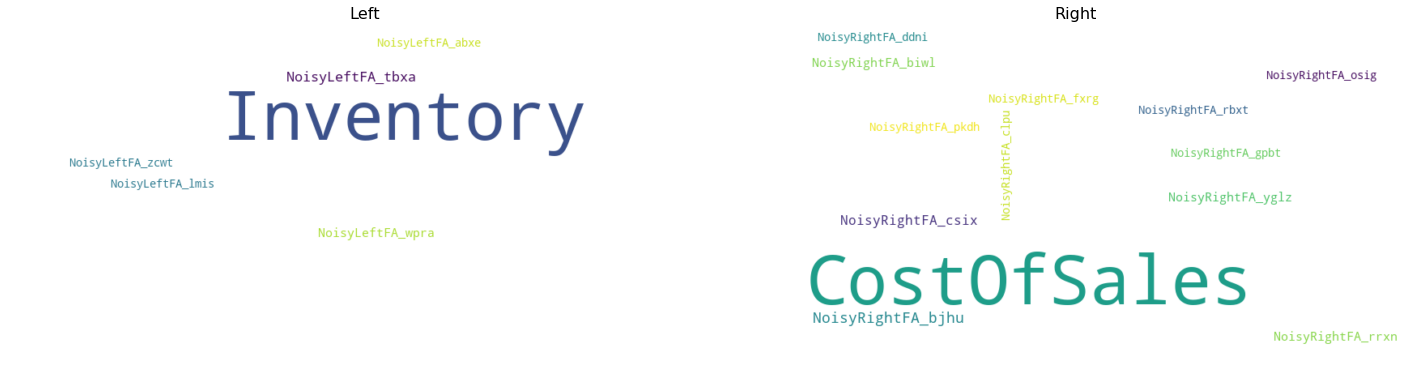

Current cluster label is  1
Left ---> [('Revenue', 1873, 93260100.0), ('Tax', 1873, 12575130.188117934), ('NoisyLeftFA_swiz', 15, 1702.0439851253575), ('NoisyLeftFA_ppcj', 15, 1588.4912567330375)]
Right ---> [('TradeReceivables', 1873, 105882418.63907678), ('NoisyRightFA_urvh', 21, 2529.560516163929), ('NoisyRightFA_mdwm', 19, 2136.2887255555556), ('NoisyRightFA_evbd', 18, 1434.8045696898278)]


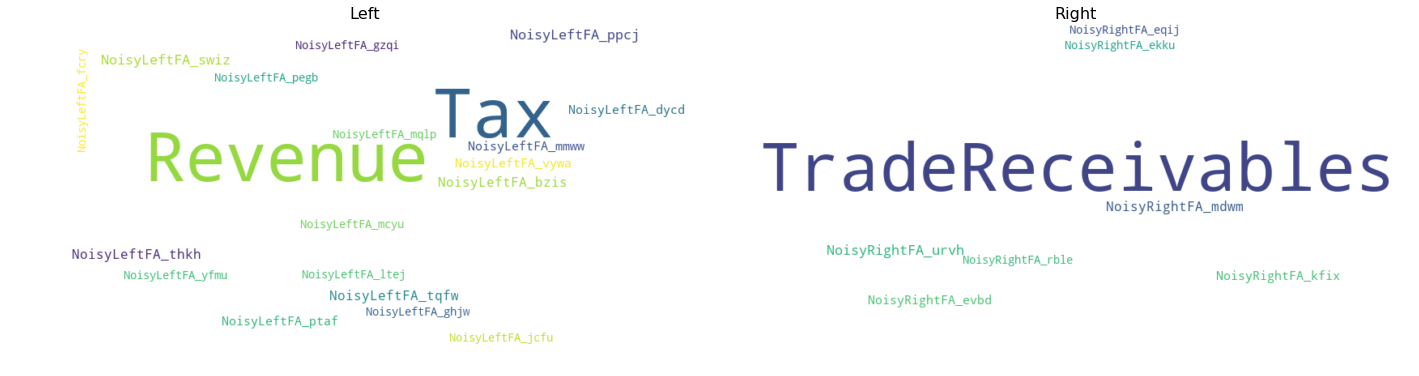

Current cluster label is  2
Left ---> [('FixedAssets', 410, 2210940.140707148), ('NoisyLeftFA_uioj', 6, 95.04441924788154), ('NoisyLeftFA_kzqt', 6, 102.2235584294111), ('NoisyLeftFA_dmik', 6, 83.81327447534765)]
Right ---> [('DepreciationExpense', 410, 2214200.0), ('NoisyRightFA_phkp', 7, 114.77276275201008), ('NoisyRightFA_kowk', 7, 129.68422632897773), ('NoisyRightFA_wduj', 6, 54.67485398334927)]


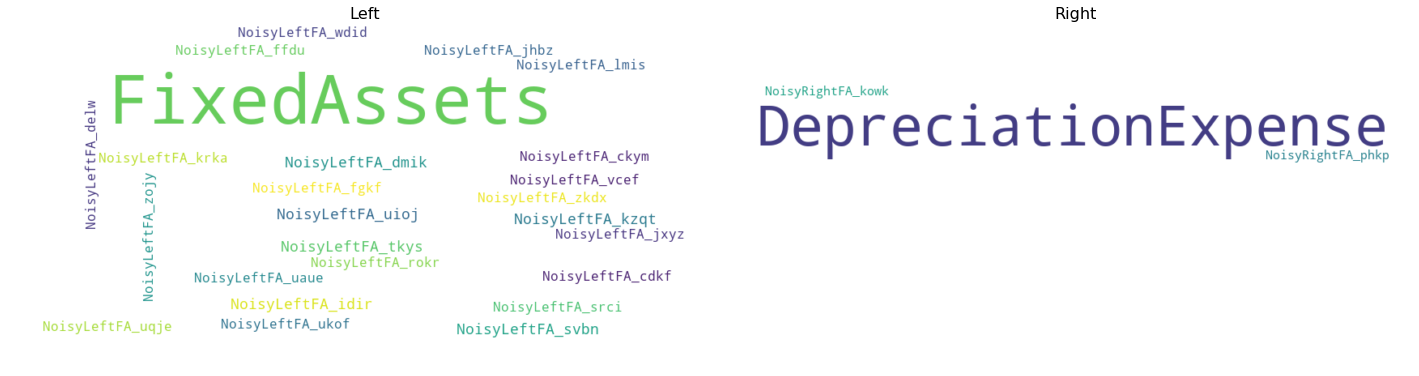

Current cluster label is  3
Left ---> [('TradeReceivables', 1172, 66115272.10944055), ('NoisyRightFA_urvh', 21, 2541.3172762118957), ('NoisyRightFA_mdwm', 19, 2136.2887255555556), ('NoisyRightFA_evbd', 18, 1434.8045696898278)]
Right ---> [('Cash', 1172, 66673757.89423147)]


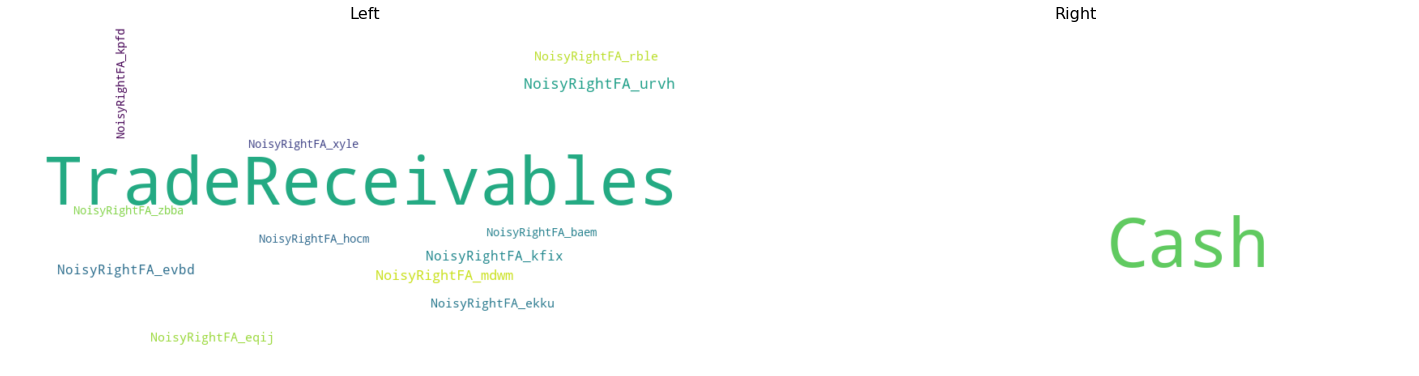

Current cluster label is  4
Left ---> [('EBPayables', 1060, 125359340.36614928), ('Tax', 1060, 33399816.23438914), ('NoisyLeftFA_qpca', 14, 1122.7101560256901), ('NoisyLeftFA_bixz', 11, 776.2709259759044)]
Right ---> [('PersonnelExpenses', 1060, 159215265.6584286), ('NoisyRightFA_sajy', 14, 1303.7044787742807), ('NoisyRightFA_uqbk', 13, 775.8968899458698), ('NoisyRightFA_vqge', 13, 1210.6407241201368)]


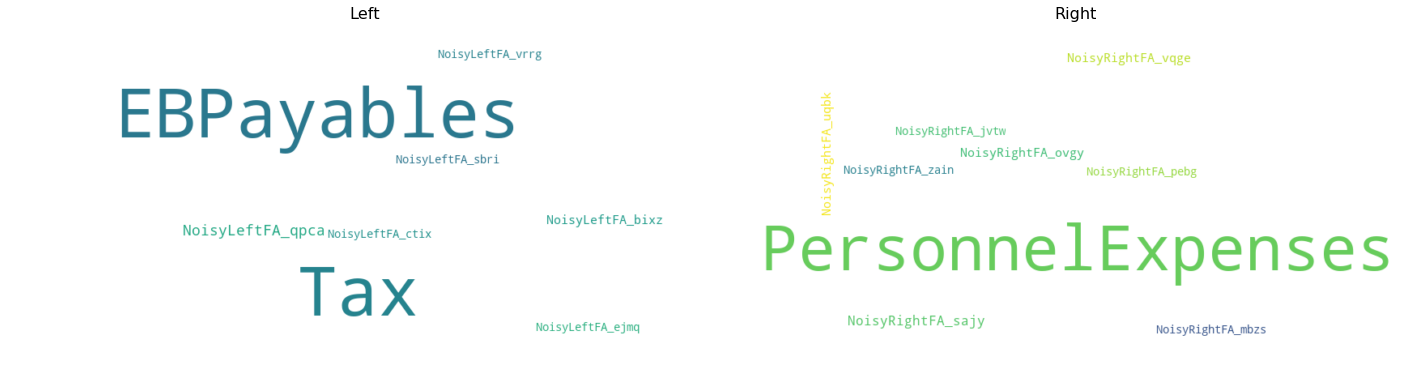

Current cluster label is  5
Left ---> [('TradePayables', 430, 2353200.0), ('NoisyLeftFA_vzfa', 7, 109.98534307047811), ('NoisyLeftFA_bsjg', 7, 150.36214520115774), ('NoisyLeftFA_tlbh', 6, 71.72079256944667)]
Right ---> [('FixedAssets', 430, 2357422.89149614), ('NoisyRightFA_dnhe', 10, 92.35911484288162), ('NoisyRightFA_wocg', 8, 112.73574488322362), ('NoisyRightFA_lgjx', 8, 197.53494953364918)]


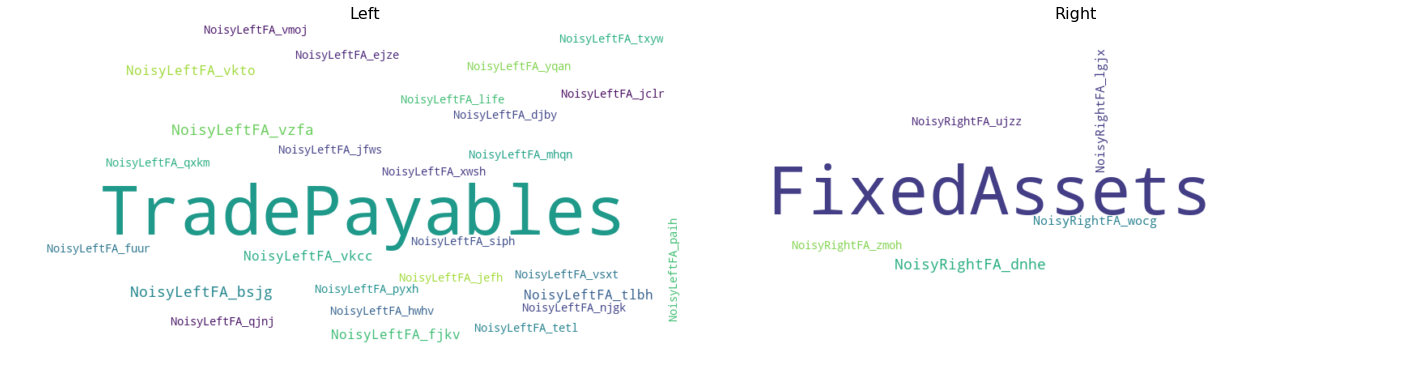

Current cluster label is  6
Left ---> [('OtherExpenses', 236, 1201100.0), ('PersonnelExpenses', 236, 1204800.0), ('PrepaidExpenses', 236, 1162100.0), ('NoisyLeftFA_xdbd', 4, 88.83602936349848)]
Right ---> [('TradePayables', 236, 3571454.0159209436), ('NoisyRightFA_ital', 5, 214.06716628209273), ('NoisyRightFA_buxk', 4, 92.1717426924935), ('NoisyRightFA_xyle', 4, 137.31110593451945)]


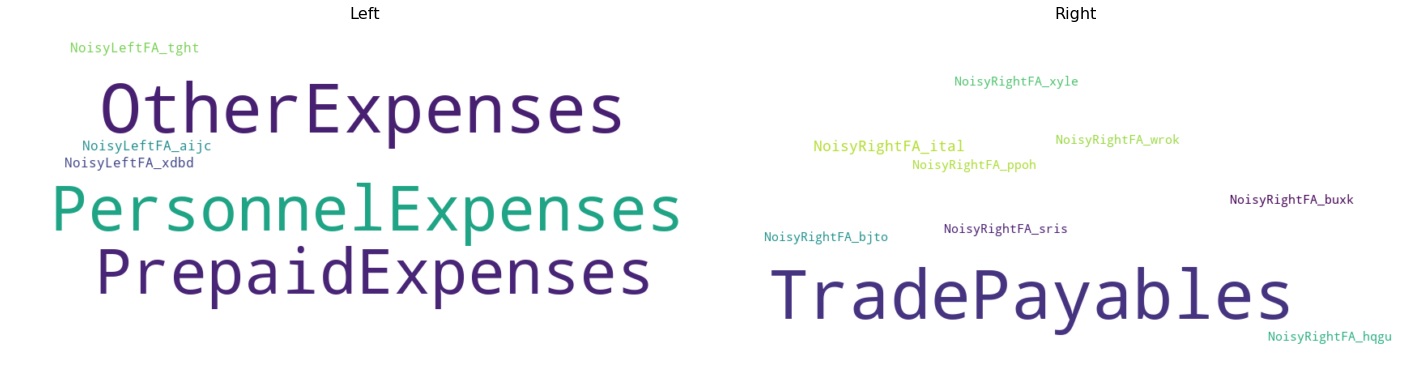

In [85]:
def findMostCommonFAs(df, labels_column="label", words_column="FA_Name", amount_column="amount", sort_mode="freq", n_top=2, vis=False, folder=""):
    if vis:
        from wordcloud import WordCloud
    for name, group in df.groupby(labels_column):
        print("Current cluster label is ", name)
        cur_data = group.groupby(words_column, as_index=False)[amount_column].agg(sum)
        fa_amounts = dict(zip(cur_data[words_column].values, cur_data[amount_column].values))
        text = {"Left": [(item[0], item[1], fa_amounts[item[0]]) for item in Counter(group[group["from"] == True][words_column].values).items()], 
                "Right": [(item[0], item[1], fa_amounts[item[0]]) for item in Counter(group[group["from"] == False][words_column].values).items()]}
        if vis:
            i = 1
            fig = plt.figure()  
        for key, data in text.items():
            if sort_mode == "freq":
#             Take the most frequent FA names
                output = sorted(data, key=lambda d: -d[1])
                to_vis = [(item[0], item[1]) for item in output]
            elif sort_mode == "amount":
                output = sorted(data, key=lambda d: -d[2])
                to_vis = [(item[0], item[2]) for item in output]
            print(key, "--->", output[:n_top])
            if vis:
                ax = fig.add_subplot(1,2,i)
                i+=1
                ax.set_title(key)
                wc = WordCloud(background_color="white", width=800, height=400, max_font_size=84, min_font_size=14, repeat=False, relative_scaling=0.8, max_words=100)
                wc.generate_from_frequencies(dict(to_vis))
                ax.axis("off")
                ax.imshow(wc, interpolation="bilinear")
        if vis:
            plt.tight_layout()
            plt.savefig(folder + "img/WordClouds/" + str(name), dpi=140, pad_inches=0.01)
            plt.show()
# ----
findMostCommonFAs(w_cnt, "label", "FA_Name", sort_mode="freq", vis=True, n_top=4, folder=cur_path)

Chapter 3 focuses on the theoretical aspects of our approach for converting original FSN into interactive one by using representation learning techniques and further clustering in latent space. It is arranged as follows. First of all, we formulate the problem which we have to solve. Then we describe in detail our sampling strategy, state the reasons to modify the existing ones (which were highlighted in 1.3.2 ) and give a proof that our sampling strategy works correctly and as expected from the business point of view. Skip-Gram model section makes a bridge between the original network and its representation in latent space. An application of different clustering methods in embedding space is discussed later. Possible ways of further developments and conclusion are given in the last part of the current chapter.